In [1]:
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10, sqrt
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Importing Tweet Data
***

In [3]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [4]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [5]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [6]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

## Helper Functions
***

In [7]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

## Miscellaneous Tests:
***

In [8]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))

'This is some     text that has   char  in it'

In [9]:
punc_test.translate(punc_test.maketrans('','',string.punctuation.replace("#","")))

'This is some  textthat has char in it'

In [10]:
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

In [11]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B','!',re_hash_test))
print(re.sub(r'\b#\b','!',re_hash_test))
print(re.sub(r'\B#\B','!',re_hash_test))

# #34 4#3 A#36 3 A! #hashtag
# #34 4!3 A!36 3 A# #hashtag
! #34 4#3 A#36 3 A# #hashtag


In [12]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'apm', 'yooo']

## Word/Token Statistics
***

In [13]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [14]:
word_counts.size

43387

In [15]:
# word_counts.head(20)

In [16]:
# word_counts.tail(20)

In [17]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [18]:
word_counts_reduce.size

43254

In [19]:
# np.setdiff1d(word_counts.index.values,word_counts_reduce.index.values)

In [20]:
# word_counts_reduce.head(20)

In [21]:
# word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [22]:
# word_counts_full_tokenizer.size

In [23]:
# word_counts_full_tokenizer.head(20)

In [24]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [25]:
# tweet_test = tweet_text.loc['2017-09-10 00:03:40'][1]
# print(tweet_test)
# tweet_test = tweet_test.lower()
# print(word_tokenize(tweet_test))
# print(tweet_test.split())
# i=0
# print(f"S: {tweet_test}");i+=1
# #     1: remove URLs:
# tweet_test = re.sub('https?://\S+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     2: remove @mentions, including those with a leading '-' or '.' : 
# tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     3: remove punctuation, but not hashtags:
# tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
# print(f"{i}: {tweet_test}");i+=1
# #     4: remove non-hashtag '#'.
# # tweet_test = re.sub('#\B','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# # tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     6: drop words of < 4 characters, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     7: drop numbers, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1

# print(word_tokenize(tweet_test))
# print(tokens_no_stopwords(tweet_test))

In [26]:
pd.set_option('display.max_colwidth', -1)

In [27]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))

timestamp
2017-09-10 00:03:40    #NaturalRemedies This Is the Only Product That Kills Viruses, Fungal Infections,... https://t.co/XUXtJZ5cBY  https://t.co/G05XM19Deg
2017-09-10 00:03:40    TAGGED 2017  #1 @ US 1-Biscayne Blvd. https://t.co/1foe57DVyC                                                                       
Name: tweet_text, dtype: object
timestamp
2017-09-10 00:03:40    [#naturalremedi, product, kill, virus, fungal, infect]
2017-09-10 00:03:40    [tag, #1, us, biscayn, blvd]                          
Name: tweet_text, dtype: object


In [28]:
# tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

In [29]:
# word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [30]:
# word_counts_full_token_clean.size

In [31]:
# word_counts_full_token_clean.head(20)

In [32]:
# word_counts_full_token_clean.tail(20)

In [33]:
# tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [34]:
# tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [35]:
# tweet_len_post[tweet_len_post.index <= 10].sum()

In [36]:
# tweet_len_post.sum()

In [37]:
# tweet_len

In [38]:
# tweet_len_post

In [39]:
# tweet_len_post[tweet_len_post.index < 11].sum()

In [40]:
# tweet_len_post[tweet_len_post.index < 11].sum()/tweet_len_post.sum()

In [41]:
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [42]:
# fig_tweet_hist = plt.figure(figsize=(16,8))
# plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
# plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
# plt.xlabel("Quantity of Tokens Per Tweet")
# plt.ylabel("Number of Tweets")
# plt.title("Histogram of Tweets by Length (Token Quantity)")
# plt.legend()
# plt.show()
# fig_tweet_hist.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')

## Skip-Gram

### Search Term

In [43]:
search_term = 'irma'

### Window Size: 1-10

In [44]:
# # comparison_type = "Min. Word Freq."
# # comparison_short = "MinWordFreq"
# comparison_type = "Window Size"
# comparison_short = "WindowSize"

In [45]:
# # eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
# vectors_series = pd.Series(np.zeros((12)))

In [46]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(0,11):
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
#     vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, min_count=i)#, window=8, workers=1, size=100, negative=i)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

In [47]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

### Comparison Functions

Need a way to write the comparison functions with a larger function that calls them.

how about writing the functions as separate, with a larger function that calls the smaller functions with an argument.

- Mean Cosine Similarity
- Sum Cosine Similarity Over Square Root of Length
- Dot Product of Tweet As Matrix Sum of Term Vectors and Search Term
- Cosine Similarity of Tweet As Matrix Sum of Term Vectors and Search Term

In [48]:
def meanCosSim(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [49]:
def sumCosSimSqrtSum(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [50]:
def dotProductOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [51]:
def cosSimOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if ((len(tweet_as_terms) > 0) & (np.all(score_matrix != np.zeros(vector_dim,)))):
        score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

Wrapper Function for the scalar comparison formulas:

In [52]:
def scalarFunctions(tweet,vector_set,formula='dp'):
    if(formula.upper() == 'DP'):
        return dotProductOfTweetMatrixTermVector(tweet,vector_set)
    elif(formula.upper() == 'MCS'):
        return meanCosSim(tweet,vector_set)
    elif(formula.upper() == 'SCSSC'):
        return sumCosSimSqrtSum(tweet,vector_set)
    elif(formula.upper() == 'CSTVS'):
        return cosSimOfTweetMatrixTermVector(tweet,vector_set)
    else:
        return np.NaN

In [53]:
# scalarFunctions(tweets_on_date.iloc[0,1],vectors_series[1],'mcs')

In [54]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [55]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [56]:
# func_type = "Dot Product of Tweet Vector and Search Term"
# func_short = "DotProduct"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the dot product of the score vector, and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [57]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
# def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [58]:
# tweet_encoded.iloc[0:5].tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[1],'mcs'))

In [59]:
# for i in range(0,11):
# #     create strings for column heads
#     sw = f'score_window_{i}'
#     mmsw = f'MM_{sw}'
    
# #     Scoring tweets in this column:
#     tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'dp'))
                                                       
# #     column of scores for this iteration
#     tweet_scores = tweet_encoded[sw]

# #     calculating Min Max Scaling for this column 
#     tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [60]:
# vectors_series.iloc[1].wv.similar_by_word("irma", topn=10, restrict_vocab=None)

In [61]:
# for i in range(0,11):
#     print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),5))

In [62]:
# fig_0 = plt.figure(figsize=(16,8),facecolor='w')

# for j in range(1,11):
#     window_label = f"{comparison_type}: {j}"
#     plt.plot(range(101),[100*len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
# plt.xlabel("Min-Max Scaled Tweet Score Threshold")
# plt.ylabel("Percent of Tweets at or above Threshold")
# plt.title(f"Percent of Tweets at or above Threshold by Word2Vec {comparison_type} ({func_type})")
# plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [63]:
# f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
# pre_score_df = pd.DataFrame(np.zeros((101,11)))
# rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [64]:
# for i in range(1,11):
#     for j in range(101):
#         f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [65]:
# print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
# print(f1_window_score_df.idxmax().max())
# print(f1_window_score_df.max().max())

In [66]:
# fig_1 = plt.figure(figsize=(16,8),facecolor='w')
# for i in range(1,11):
#     plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
# plt.xlabel("Min-Max Scaled Tweet Score Threshold")
# plt.ylabel("F1 Score of Tweets Above Threshold")
# plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
# plt.legend();
# # fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Hidden Layer Dimensionality (window size 7)

In [67]:
# comparison_type = "Hidden Layer Dimensionality"
# comparison_short = "HLD"

In [68]:
# # eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
# vectors_series = pd.Series(np.zeros((11)))

In [69]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(1,11):
#     hidden_layer_dim = 50*i
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size 8, min count 1, and Skip-Gram (Hidden Layer Dim. Test)
#     vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=hidden_layer_dim, seed=1, sg=1, negative=5)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

## 2min 29s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [70]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
## 6.67 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [71]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=50)
## 16.1 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [72]:
# taking values from iterative test
HD=150
MWC=5
WWS=1
NS=1
EP=25
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

opt_vector_model = Word2Vec(tweets_tokens, min_count=MWC, window=WWS, workers=1, size=HD, seed=1, sg=1, negative=NS)
    
# train the model over 10 epochs
opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=EP)

(2482287, 3224100)

In [73]:
# opt_vector_model.wv.get_vector('irma')

In [74]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

def_vector_model = Word2Vec(tweets_tokens, seed=1, sg=1)
    
# train the model over 10 epochs
#def_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

### AU-ROC Score

In [75]:
# default parameters for Word2Vec:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'd_sw_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(def_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [76]:
# Optimal parameters for Word2Vec:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'o_sw_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(opt_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [77]:
tweet_encoded.columns

Index(['index', 'irma_rel', 'tweet', 'timestamp', 'tweet_id', 'tweet_text',
       'user_id', 'tweet_coords', 'tweet_coords_list', 'tweet_long',
       'tweet_lat', 'location', 'enc_url', 'tweet_lang', 'hashtags', 'd_sw_dp',
       'MM_d_sw_dp', 'd_sw_mcs', 'MM_d_sw_mcs', 'd_sw_scssc', 'MM_d_sw_scssc',
       'd_sw_cstvs', 'MM_d_sw_cstvs', 'o_sw_dp', 'MM_o_sw_dp', 'o_sw_mcs',
       'MM_o_sw_mcs', 'o_sw_scssc', 'MM_o_sw_scssc', 'o_sw_cstvs',
       'MM_o_sw_cstvs'],
      dtype='object')

In [78]:
# tweet_encoded[['tweet_id','timestamp','irma_rel','tweet','sw_dp','MM_sw_dp']].to_csv(r'./190930_wordScores.csv')

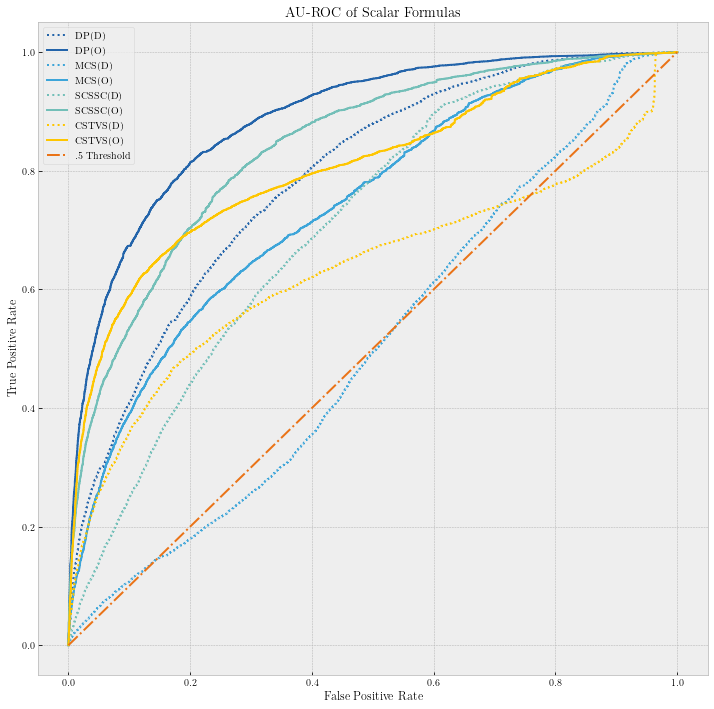

In [79]:
color_list = {'dp':"#2364AA",'mcs':"#3DA5D9",'scssc':"#73BFB8",'cstvs':"#FEC601",'mid':"#EA7317"}
line_list = {'d':":",'o':"-"}
fig_roc_s = plt.figure(figsize=(12,12),facecolor='w')
for i in ['dp','mcs','scssc','cstvs']:
    for j in ['d','o']:
#     for j in ['o']:   
        fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_{j}_sw_{i}'])
#         label_text = i.upper()
        label_text = i.upper()+"("+j.upper()+")"
        plt.plot(fpr,tpr,label=label_text,linestyle=line_list.get(j),color=color_list.get(i))
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold",color=color_list.get('mid'))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AU-ROC of Scalar Formulas")
plt.legend()
plt.show()
fig_roc_s.savefig(f'./figures/scalar_roc_d_curve.pdf',bbox_inches='tight')

## Optimized Loops

In [ ]:
[10,25,50,100,125,250,500]

In [ ]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')
# tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]
# tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)
# search_term = 'irma'
# # Hidden Layer Dimensions (hld)
# # Minimum Word Count (mwc)
# # Word Window Size (wws)
# # Negative Sampling (ns)
# # Epochs (ep)
# # Scoring formulas (sf)

In [ ]:
# roc_df = pd.DataFrame()
# for hld in range(50,501,50):
#     for mwc in range(10):
#         for wws in range(1,11):
#             for ns in range(10):
#                 for ep in [10,25,50,100,125,250,500]:
#                     vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, workers=1,
#                                             size = hld,
#                                             min_count = mwc,
#                                             window = wws,
#                                             negative = ns)
#                     vector_model.train(tweets_tokens,
#                                        total_examples = len(tweet_text),
#                                        epochs=ep)
#                     for sf in ['dp','mcs','scssc','cstvs']:
# #                         score tweets
#                         tweet_encoded['score'] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vector_model,sf))
# #                         convert to min-max
#                         tweet_scores = tweet_encoded['score']
#                         tweet_encoded['mm'] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())
# #                         get AU-ROC
#                         roc_row_score = roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['mm'])
# #                         add to DataFrame
#                         roc_row = pd.DataFrame([roc_row_score,hld,mwc,wwc,ns,ep,sf]).T
#                         roc_df = roc_df.append(roc_row, ignore_index=True)
# #                         roc_df = pd.concat([roc_df,roc_row.T],axis=0)
#                         roc_row

In [ ]:
# roc_df.to_csv('./optimal.csv')

In [ ]:
# roc_df.rename(columns={0:'AUROC',1:'HLD',2:'MWC',3:'WWS',4:'NS',5:'EP',6:'SF'}).sort_values('AUROC',ascending=False)

In [ ]:
roc_df.loc[14032]

In [ ]:
for i in ['dp','mcs','scssc','cstvs']:
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_sw_{i}']),4))

### Saed's tweets:

In [ ]:
# s_tweets = pd.read_csv(r'./irma_3days_tweets.csv')

In [ ]:
# s_tweets.head(5)

In [ ]:
# s_tweets_tokens = s_tweets['text'].apply(tokens_no_stopwords)
# s_tweets_v_model = Word2Vec(s_tweets_tokens,
#                            min_count=MWC,
#                            window = WWS,
#                            workers=1,
#                            size=HD,
#                            seed=1,
#                            sg=1,
#                            negative = NS)
# s_tweets_v_model.train(s_tweets_tokens, total_examples = len(s_tweets['text']), epochs=EP)

In [ ]:
# s_tweets['dp_score'] = s_tweets['text'].apply(scalarFunctions,args=(opt_vector_model,'dp'))
# s_tweets_scores = s_tweets['dp_score']
# s_tweets['mm_dp_score'] = ((s_tweets_scores - s_tweets_scores.min())* 100) / (s_tweets_scores.max() - s_tweets_scores.min())

In [ ]:
# s_tweets.to_csv(r'./irma_3days_tweets_scored.csv')

In [ ]:
# s_tweets.sort_values('mm_dp_score',ascending=False)

### Related Words by 1 Hour Increments

In [ ]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("1HR")
end_date = pd.to_datetime("2017-09-11 00:00:00")
top_num_words = 20
search_term = 'irma'

In [ ]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]
    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    opt_vector_model_1hr = Word2Vec(tweets_tokens, min_count=MWC, window=WWS, workers=1, size=HD, seed=1, sg=1, negative=NS)
    opt_vector_model_1hr.train(tweets_tokens, total_examples=len(tweet_text), epochs=EP)
    opt_word_matrix_1hr = opt_vector_model_1hr.wv[opt_vector_model_1hr.wv.vocab]
    terms_from_range = pd.DataFrame.from_records(opt_vector_model_1hr.wv.most_similar(search_term,topn=top_num_words),columns=[tweet_day,"Cos_Sim"])
    related_words = pd.concat([related_words,terms_from_range],axis=1)

In [ ]:
# related_words.iloc[:,0::2].to_csv(r'./190928_words.csv')

In [ ]:
# related_words.to_csv('./top_words_no_scores.csv')

### Network Graphs

In [80]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [92]:
def dummy_fun(doc):
    return doc

t_vect = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

In [93]:
t_vect.fit(tweets_tokens)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=<function dummy_fun at 0x131b92488>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern=None,
                tokenizer=<function dummy_fun at 0x131b92488>, use_idf=True,
                vocabulary=None)

In [95]:
t_vect.vocabulary_.items()

dict_items([('wind', 14144), ('mph', 10219), ('n', 10282), ('baromet', 4996), ('steadi', 12787), ('temperatur', 13171), ('f', 7367), ('rain', 11489), ('today', 13356), ('humid', 8596), ('alway', 4593), ('beauti', 5082), ('regardless', 11641), ('circumst', 5998), ('palm', 10827), ('coast', 6080), ('florida', 7613), ('#carpool', 512), ('#orlando', 2476), ('#kirkmanroad', 1902), ('rideshar', 11790), ('split', 12678), ('cost', 6293), ('take', 13079), ('turn', 13551), ('nah', 10288), ('chillin', 5926), ('eye', 7357), ('never', 10384), ('get', 7928), ('red', 11603), ('feel', 7469), ('bout', 5376), ('seein', 12139), ('travi', 13462), ('beak', 5069), ('board', 5296), ('window', 14149), ('kitti', 9214), ('pettin', 10999), ('temp', 13169), ('hum', 8592), ('dewp', 6733), ('bar', 4981), ('hpa', 8572), ('inch', 8749), ('kn', 9221), ('proud', 11359), ('local', 9539), ('radio', 11482), ('news', 10388), ('anim', 4659), ('shelter', 12256), ('peopl', 10962), ('bad', 4935), ('much', 10231), ('good', 8039

In [ ]:
# token_counts = tweets_tokens.apply(pd.Series).stack().value_counts()

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
# for pair in word_pairs:
#     edge_weight = vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > .80:
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')

In [98]:
num_words = 10
tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
for word_count in t_vect.vocabulary_.items():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
    tweet_graph.add_node(word_count[0],tfidf=word_count[1])
for word in list(opt_vector_model.wv.vocab.keys()):
    word_scores = opt_vector_model.wv.most_similar(word, topn=num_words)
    for i in range(num_words):
        tweet_graph.add_edge(word,word_scores[i][0],weight=word_scores[i][1])
nx.write_gexf(tweet_graph,path=f'./tweet_graph_{num_words}_tfidf.gexf')

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'scssc'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
for i in range(1,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),3))

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_hld_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {25*j + 25}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or Above Threshold")
plt.title(f"Percent of Tweets at or Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_hld_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

In [ ]:
fig_hld_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    window_label = f"{comparison_type}: {25*i + 25}"
    plt.plot(f1_window_score_df.iloc[:,i],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_hld_2.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Negative Sampling (window size 7, dim = 100)

In [ ]:
comparison_type = "Negative Sampling Test"
comparison_short = "NS"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    ns_size = i
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
vectors_series

In [ ]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_ns_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(0,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100 * len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets Above Threshold")
plt.title(f"Percent of Tweets Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

#fig_ns_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [ ]:
from scipy.stats import norm
print(np.linspace(1,100,100))
#norm.cdf(tweet_encoded['MM_score_window_1'],np.linspace(1,100,100))

In [ ]:
plt.hist(tweet_encoded['MM_score_window_1'].values,bins=100)

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(0,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
ns_test = pd.DataFrame(pd.concat([f1_window_score_df.idxmax().rename('MM_Score'),f1_window_score_df.max().rename('F1_Score_Max')],axis=1))
ns_test['Neg_Samp_Size'] = pd.Series(range(0,11))

In [ ]:
ns_test[['Neg_Samp_Size','MM_Score','F1_Score_Max']]

In [ ]:
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().idxmax())

In [ ]:
fig_ns_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(0,11):
    if i == f1_window_score_df.max().idxmax():
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i} (F1 Max)",linestyle=":")
    else:
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_ns_2.savefig(f'./figures/neg_samp_size_1-10_F1Score.pdf',bbox_inches='tight')

In [ ]:
tweet_to_score = tweet_full[tweet_full.tweet_text.str.contains('will post again')].tweet_text[0]

ScoreTweetFromVectors(tweet_to_score,vector_set=vectors_series.iloc[1])
# print(type(tweet_to_score))
# print(tweet_to_score)

In [ ]:
print(tweet_to_score)

In [ ]:
tweet_encoded[(tweet_encoded['score_window_1'] > 22.85) & (tweet_encoded['score_window_1'] < 22.88)]['MM_score_window_1']

In [ ]:
roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
plt.plot(fpr,tpr,label='Score of Text Module')
plt.plot([0,1],[0,1],label='.5 AUROC Threshold')
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/text_mod_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')